In [1]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable


In [2]:
path_to_tree = "../data/example_birds/anc_kg.treefile"
path_to_states = "../data/example_birds/genes_states.tsv"
path_to_leaves = "../data/example_birds/leaves_birds_states.tsv"


In [4]:
tree = tree = PhyloTree(path_to_tree, format=1)


In [5]:
tree.describe()


Number of leaf nodes:	764
Total number of nodes:	1526
Rooted:	No
Most distant node:	Crypturellus_undulatus
Max. distance:	0.447375


In [6]:
# print(tree.get_ascii())
# tree.show()


In [6]:
adtype = {
    "Site": np.int32,
    "p_A":  np.float32,
    "p_C":  np.float32,
    "p_G":  np.float32,
    "p_T":  np.float32
}
anc = pd.read_csv(path_to_states, sep="\t", comment='#', dtype=adtype)
leaves = pd.read_csv(path_to_leaves, sep="\t", dtype=adtype)


In [7]:
leaves.head(2)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Acanthisitta_chloris,1,1,-,0.0,0.0,0.0,0.0
1,Acanthisitta_chloris,1,2,-,0.0,0.0,0.0,0.0


## Adapt anc table (part adding & site replacement)

In [8]:
anc.head(2)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node1,1,1,A,0.9619,0.00923,0.02219,0.00668
1,Node1,1,2,T,0.0080,0.05699,0.00347,0.93154


In [9]:
one_leaf = leaves[leaves.Node == leaves.Node.sample().values[0]].sort_values([
    "Part", "Site"])


In [10]:
one_leaf


,Node,Part,Site,State,p_A,p_C,p_G,p_T
441330,Cygnus_atratus,1,1,-,0.0,0.0,0.0,0.0
441331,Cygnus_atratus,1,2,-,0.0,0.0,0.0,0.0
441332,Cygnus_atratus,1,3,-,0.0,0.0,0.0,0.0
441333,Cygnus_atratus,1,4,-,0.0,0.0,0.0,0.0
441334,Cygnus_atratus,1,5,-,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8323807,Cygnus_atratus,12,1916,-,0.0,0.0,0.0,0.0
8323808,Cygnus_atratus,12,1917,-,0.0,0.0,0.0,0.0
8323809,Cygnus_atratus,12,1918,-,0.0,0.0,0.0,0.0
8323810,Cygnus_atratus,12,1919,-,0.0,0.0,0.0,0.0


In [11]:
replication_factor = anc.shape[0] / one_leaf.shape[0]
assert replication_factor == int(replication_factor)
replication_factor = int(replication_factor)
replication_factor


762

In [12]:
anc = anc.sort_values(["Node", "Site"])


In [13]:
anc.head()


,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node1,1,1,A,0.96190,0.00923,0.02219,0.00668
705,Node1,2,1,A,0.99999,0.00000,0.00001,0.00000
909,Node1,3,1,A,0.99840,0.00011,0.00142,0.00008
2478,Node1,4,1,A,0.88981,0.03113,0.05654,0.02252
3186,Node1,5,1,A,0.99999,0.00000,0.00001,0.00000


In [14]:
np.tile(one_leaf.Site.values, replication_factor)


array([   1,    2,    3, ..., 1918, 1919, 1920], dtype=int32)

In [108]:
anc["Part"] = np.tile(one_leaf.Part.values, replication_factor)
anc["Site"] = np.tile(one_leaf.Site.values, replication_factor)
anc.head()


,Node,Site,State,p_A,p_C,p_G,p_T,Part
8618325,Node1,1,A,0.96190,0.00923,0.02219,0.00668,1
8618326,Node1,2,T,0.00800,0.05699,0.00347,0.93154,1
8618327,Node1,3,G,0.04505,0.00893,0.93955,0.00646,1
8618328,Node1,4,A,0.99358,0.00052,0.00553,0.00037,1
8618329,Node1,5,A,0.83463,0.03430,0.01926,0.11182,1


In [109]:
leaves.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652300 entries, 0 to 8652299
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Part    int64  
 2   Site    int32  
 3   State   object 
 4   p_A     float32
 5   p_C     float32
 6   p_G     float32
 7   p_T     float32
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 363.1+ MB


In [112]:
anc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8629650 entries, 8618325 to 872024
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Site    int32  
 2   State   object 
 3   p_A     float32
 4   p_C     float32
 5   p_G     float32
 6   p_T     float32
 7   Part    int64  
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 428.0+ MB


In [113]:
anc.Node.str.startswith("Node").sum() == anc.shape[0]


True

In [124]:
anc.to_csv("../data/interim/anc_kg_states_birds.tsv", sep="\t", index=None)


In [114]:
states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()


(17281950, 8)


,Node,Site,State,p_A,p_C,p_G,p_T,Part
0,Acanthisitta_chloris,1,-,0.0,0.0,0.0,0.0,1
1,Acanthisitta_chloris,2,-,0.0,0.0,0.0,0.0,1
2,Acanthisitta_chloris,3,-,0.0,0.0,0.0,0.0,1
3,Acanthisitta_chloris,4,-,0.0,0.0,0.0,0.0,1
4,Acanthisitta_chloris,5,-,0.0,0.0,0.0,0.0,1


In [115]:
states.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17281950 entries, 0 to 8362211
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Site    int32  
 2   State   object 
 3   p_A     float32
 4   p_C     float32
 5   p_G     float32
 6   p_T     float32
 7   Part    int64  
dtypes: float32(4), int32(1), int64(1), object(2)
memory usage: 857.0+ MB


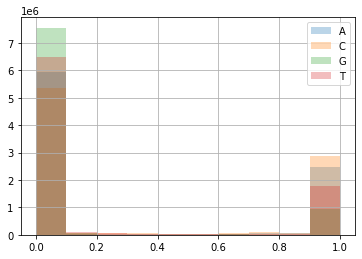

In [15]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()


## 10% of positions are uncertain

In [16]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)


True     0.953422
False    0.046578
dtype: float64

Text(0.5, 1.0, 'Entropy')

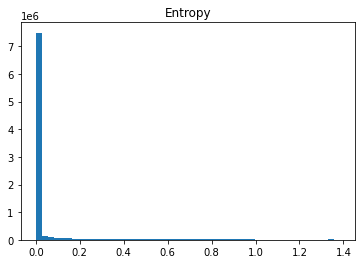

In [17]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]].values, axis=1)
plt.hist(mentr, bins=50)
plt.title("Entropy")


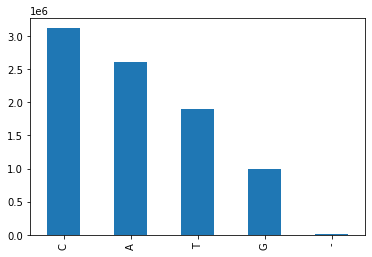

In [121]:
anc.State.value_counts().plot.bar()


## MUTSPEC

In [18]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict
from itertools import groupby


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable


In [4]:
# label = "birds_24-03-22-20-56-51"
label = "birds_31-03-22-21-08-54"

In [22]:
_path = "../data/processed/birds/20-05-22-17-24-26"
mutations = pd.read_csv(f"{_path}/mutations.csv", sep="\t")
edge_mutspec12 = pd.read_csv(f"{_path}/mutspec12.csv", sep="\t")
edge_mutspec192 = pd.read_csv(f"{_path}/mutspec192.csv", sep="\t")

In [26]:
mutations.head()


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
0,A[A>T]C,0,17,2,AAC,ATC,N,I,Node1,Acanthisitta_chloris,1
1,T[C>T]G,1,30,3,TTC,TTT,F,F,Node1,Acanthisitta_chloris,1
2,T[C>T]C,1,63,3,ATC,ATT,I,I,Node1,Acanthisitta_chloris,1
3,C[A>T]C,2,66,3,CCA,CCT,P,P,Node1,Acanthisitta_chloris,1
4,C[C>A]A,2,111,3,CCC,CCA,P,P,Node1,Acanthisitta_chloris,1


In [25]:
mutations.shape

(498035, 11)

### QC of reconstructed ancestral sequences 
using extracted mutations

**1 Distribution of edge mutation number**

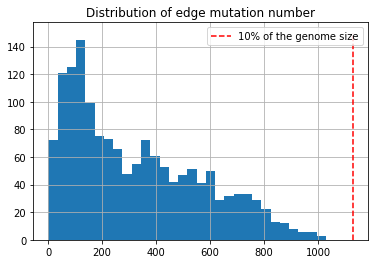

In [27]:
edge_mut_num = mutations.groupby("AltNode").apply(len)
of_genome_10percent = mutations.groupby("Gene")["PosInGene"].max().sum() / 10

edge_mut_num.hist(bins=30)
plt.vlines([of_genome_10percent], 0, 150, "r", "dashed", label="10% of the genome size")
plt.title("Distribution of edge mutation number")
plt.legend()
plt.show()

**2 Look at nonsense mutations (AA>\* or \*>AA)**

In [28]:
print("Number of mutations:", mutations.shape[0])

Number of mutations: 498035


In [30]:
nonsense_muts = mutations[
    (mutations.Label < 0) & 
    (mutations.Mut.str.fullmatch("[ACGT]\[[ACGT]>[ACGT]\][ACGT]"))
]
nonsense_muts

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
7456,A[C>A]T,-1,657,3,TAC,TAA,Y,*,Node366,Node369,10
51900,A[A>G]A,-1,17,2,AAA,AGA,K,*,Node635,Node648,8
73480,G[A>C]C,-1,18,3,AGA,AGC,*,S,Node648,Node649,8
74193,A[G>C]A,-1,17,2,AGA,ACA,*,T,Node648,Heliornis_fulica,8
136658,T[T>A]A,-1,1499,2,TTA,TAA,L,*,Node650,Node651,10
151836,C[C>T]A,-1,16,1,CAA,TAA,Q,*,Node383,Node384,7
162523,C[A>T]A,-1,1147,1,AAA,TAA,K,*,Node522,Node525,6
203690,A[T>A]A,-1,1146,3,TAT,TAA,Y,*,Node594,Node595,6
235287,A[A>C]C,-1,18,3,TAA,TAC,*,Y,Node385,Node386,7
235563,T[A>G]A,-1,17,2,TAA,TGA,*,W,Node385,Node388,7


In [31]:
genes_order = "ATP6 ATP8 COX1 COX2 COX3 CYTB ND1 ND2 ND3 ND4 ND4L ND5".split()

In [33]:
_mutations_description = mutations[
    (mutations.Mut.str.fullmatch("[ACGT]\[[ACGT]>[ACGT]\][ACGT]"))
].groupby(["Label", "Gene"]).Mut.count().reset_index()
_mutations_description["Label"] = _mutations_description.Label.map(
    {-1: "nns", 0: "other", 1: "syn", 2: "ffd"})

_pivot_mutations = pd.pivot_table(
    _mutations_description,
    values="Mut", index="Gene", columns="Label", fill_value=0
)[['syn', 'ffd', 'other', 'nns']]

_pivot_mutations.index = _pivot_mutations.index.map(
    {i: x for i, x in enumerate(genes_order, 1)})
_pivot_mutations


Label,syn,ffd,other,nns
Gene,,,,
ATP6,9315,19085,4055,0
ATP8,1741,2952,2450,0
COX1,23514,41117,2015,0
COX2,10649,16354,2749,2
COX3,11315,18231,2901,2
CYTB,16237,27492,5509,5
ND1,17121,27156,4726,3
ND2,15609,27468,10714,3
ND3,4816,8410,2831,0


**We observe very small number of nonsense mutations associated with stopcodons. Good result.**

**12 component MutSpec**

In [40]:
# sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
# plt.title("Synonymous mutational spectra")
# plt.savefig(f"../figures/{label}_mutspec_syn.svg")
# plt.show()


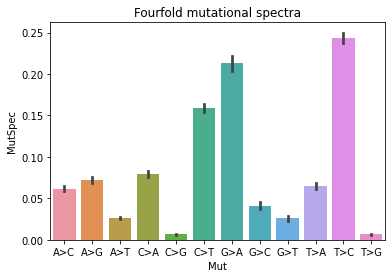

In [29]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_ff,
            order=sorted(edge_mutspec12_ff.Mut.unique()))
plt.title("Fourfold mutational spectra")
# plt.savefig(f"../figures/{label}_mutspec12_ff.svg")
plt.show()


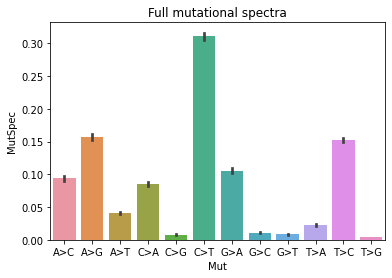

In [30]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_all,
            order=sorted(edge_mutspec12_all.Mut.unique()))
plt.title("Full mutational spectra")
# plt.savefig(f"../figures/{label}_mutspec12_all.svg")
plt.show()


**192 component MutSpec**

[first link](https://stackoverflow.com/questions/51818724/plot-two-levels-of-x-ticklabels-on-a-pandas-multi-index-dataframe)

[used link](https://stackoverflow.com/a/39502106/14998254)

In [31]:
tmp_df = pd.DataFrame({"MutExt": edge_mutspec192_ff.Mut.unique()})
tmp_df["Mut"] = tmp_df.MutExt.str.get(2) + ">" + tmp_df.MutExt.str.get(4)
tmp_df["Context"] = tmp_df.MutExt.str.get(
    0) + tmp_df.MutExt.str.get(2) + tmp_df.MutExt.str.get(-1)
tmp_df.sort_values(["Mut", "Context"], inplace=True)
order192 = tmp_df.MutExt.values


In [32]:
edge_mutspec192_ff["MutBase"] = edge_mutspec192_ff.Mut.str.get(
    2) + ">" + edge_mutspec192_ff.Mut.str.get(4)
edge_mutspec192_ff["Context"] = edge_mutspec192_ff.Mut.str.get(
    0) + edge_mutspec192_ff.Mut.str.get(2) + edge_mutspec192_ff.Mut.str.get(-1)

edge_mutspec192_all["MutBase"] = edge_mutspec192_all.Mut.str.get(
    2) + ">" + edge_mutspec192_all.Mut.str.get(4)
edge_mutspec192_all["Context"] = edge_mutspec192_all.Mut.str.get(
    0) + edge_mutspec192_all.Mut.str.get(2) + edge_mutspec192_all.Mut.str.get(-1)


In [33]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 7,
    }
    rotation = 90
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in label_len(df.index, level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec192, label="Mutational spectra", filepath=None):
    df = edge_mutspec192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(111)
    sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192,
                order=order192, errwidth=1, ax=fig.gca())

    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()


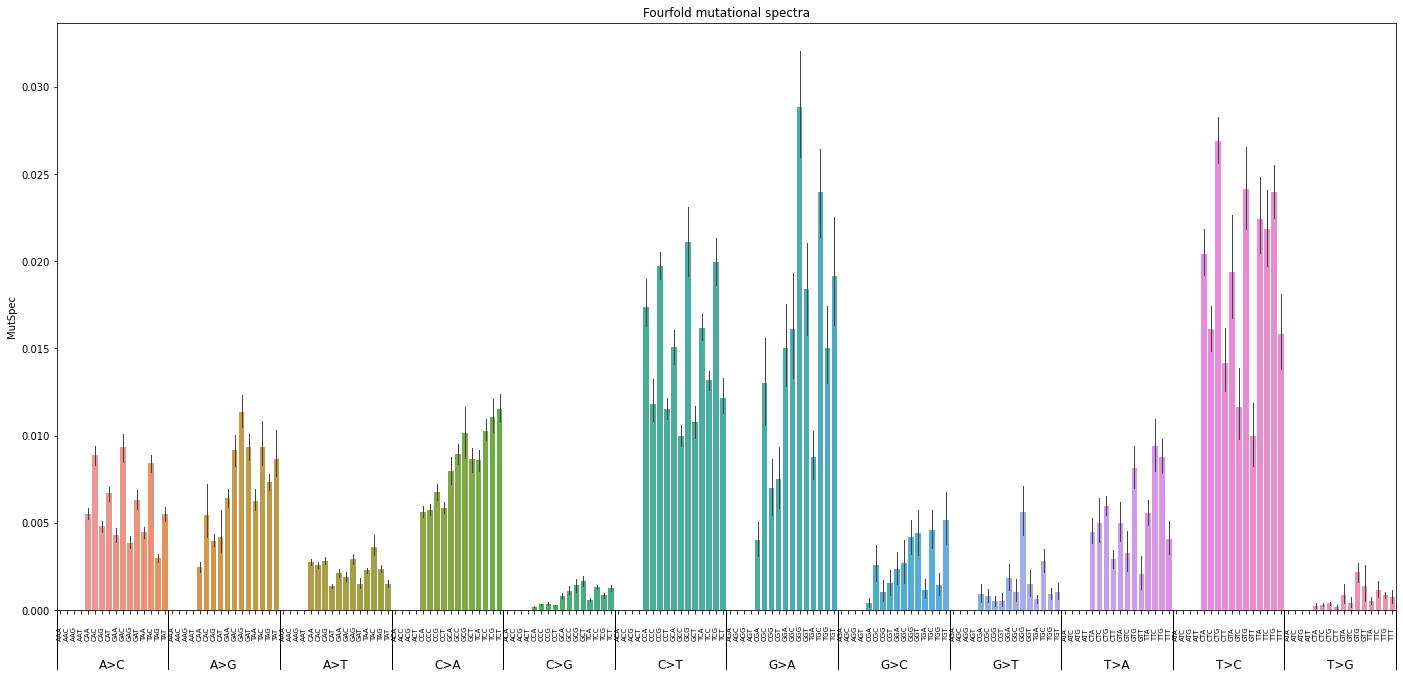

In [35]:
plot_mutspec192(edge_mutspec192_ff, "Fourfold mutational spectra", f"../figures/{label}_mutspec192_ff.svg")

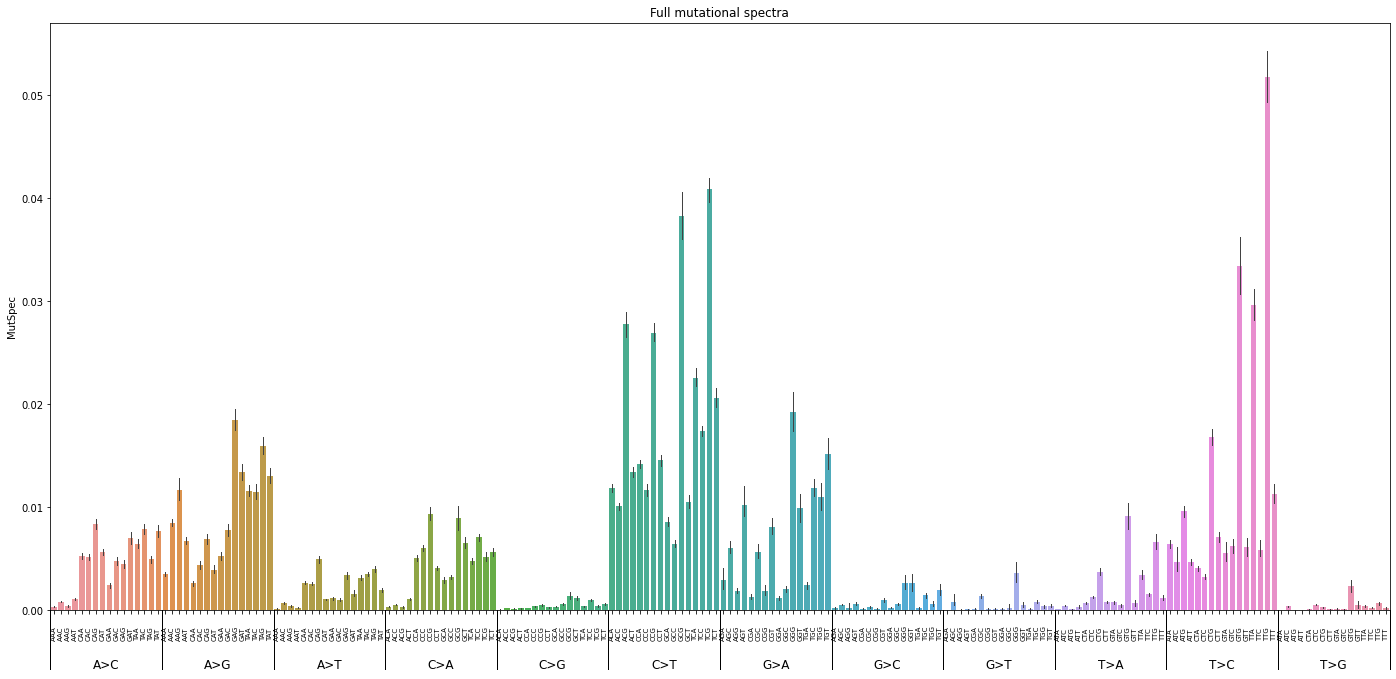

In [36]:
plot_mutspec192(edge_mutspec192_all, "Full mutational spectra", f"../figures/{label}_mutspec192_all.svg")

In [114]:
# plt.figure(figsize=(18, 10))
# sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec192_ff, order=order192, errwidth=1)
# plt.title("Fourfold mutational spectra")
# plt.xticks(rotation=90, fontsize=7)
# plt.savefig(f"../figures/{label}_mutspec192_ff.svg")
# plt.show()


**We need to get reverse-complecent mutations**

Because:
- genes are on light strand
- usually we look at heavy strand mutspec

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12915-019-0668-y/MediaObjects/12915_2019_668_Fig2_HTML.png" width=800px>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Map_of_the_human_mitochondrial_genome.svg/800px-Map_of_the_human_mitochondrial_genome.svg.png" width=800px>

In [37]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut


In [38]:
rev_comp("A[G>T]C")


'G[C>A]T'

In [39]:
# mutations["Mut"] = mutations["Mut"].str.translate(translator)
# mutations["MutExt"] = mutations["MutExt"].str.translate(translator)

# complementation for 12comp
edge_mutspec12_ff["Mut"] = edge_mutspec12_ff["Mut"].str.translate(translator)
edge_mutspec12_all["Mut"] = edge_mutspec12_all["Mut"].str.translate(translator)

# reverse complementation for 192comp
edge_mutspec192_ff["Mut"] = edge_mutspec192_ff.Mut.apply(rev_comp)
edge_mutspec192_all["Mut"] = edge_mutspec192_all.Mut.apply(rev_comp)


In [40]:
edge_mutspec192_ff


,Mut,ObsFr,Divisor,RawMutSpec,MutSpec,RefNode,AltNode,MutBase,Context
0,G[G>A]G,25,270,0.092593,0.008308,Node1,Acanthisitta_chloris,C>T,CCC
1,T[G>A]G,24,198,0.121212,0.010876,Node1,Acanthisitta_chloris,C>T,CCA
2,G[G>T]G,21,270,0.077778,0.006979,Node1,Acanthisitta_chloris,C>A,CCC
3,T[G>T]G,20,198,0.101010,0.009064,Node1,Acanthisitta_chloris,C>A,CCA
4,T[T>G]A,18,156,0.115385,0.010353,Node1,Acanthisitta_chloris,A>C,TAA
...,...,...,...,...,...,...,...,...,...
292219,C[A>C]C,0,9,0.000000,0.000000,Node144,Pseudoleistes_virescens,T>G,GTG
292220,A[A>C]G,0,32,0.000000,0.000000,Node144,Pseudoleistes_virescens,T>G,CTT
292221,T[C>G]C,0,4,0.000000,0.000000,Node144,Pseudoleistes_virescens,G>C,GGA
292222,C[G>C]G,0,78,0.000000,0.000000,Node144,Pseudoleistes_virescens,C>G,CCG


**12 component MutSpec**

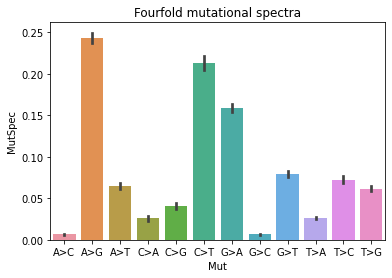

In [41]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_ff,
            order=sorted(edge_mutspec12_ff.Mut.unique()))
plt.title("Fourfold mutational spectra")
plt.savefig(f"../figures/{label}_mutspec12_ff.svg")
plt.show()


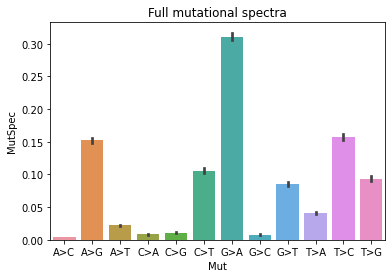

In [42]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec12_all,
            order=sorted(edge_mutspec12_all.Mut.unique()))
plt.title("Full mutational spectra")
plt.savefig(f"../figures/{label}_mutspec12_all.svg")
plt.show()


**192 component MutSpec**

In [43]:
edge_mutspec192_ff["MutBase"] = edge_mutspec192_ff.Mut.str.get(
    2) + ">" + edge_mutspec192_ff.Mut.str.get(4)
edge_mutspec192_ff["Context"] = edge_mutspec192_ff.Mut.str.get(
    0) + edge_mutspec192_ff.Mut.str.get(2) + edge_mutspec192_ff.Mut.str.get(-1)

edge_mutspec192_all["MutBase"] = edge_mutspec192_all.Mut.str.get(
    2) + ">" + edge_mutspec192_all.Mut.str.get(4)
edge_mutspec192_all["Context"] = edge_mutspec192_all.Mut.str.get(
    0) + edge_mutspec192_all.Mut.str.get(2) + edge_mutspec192_all.Mut.str.get(-1)

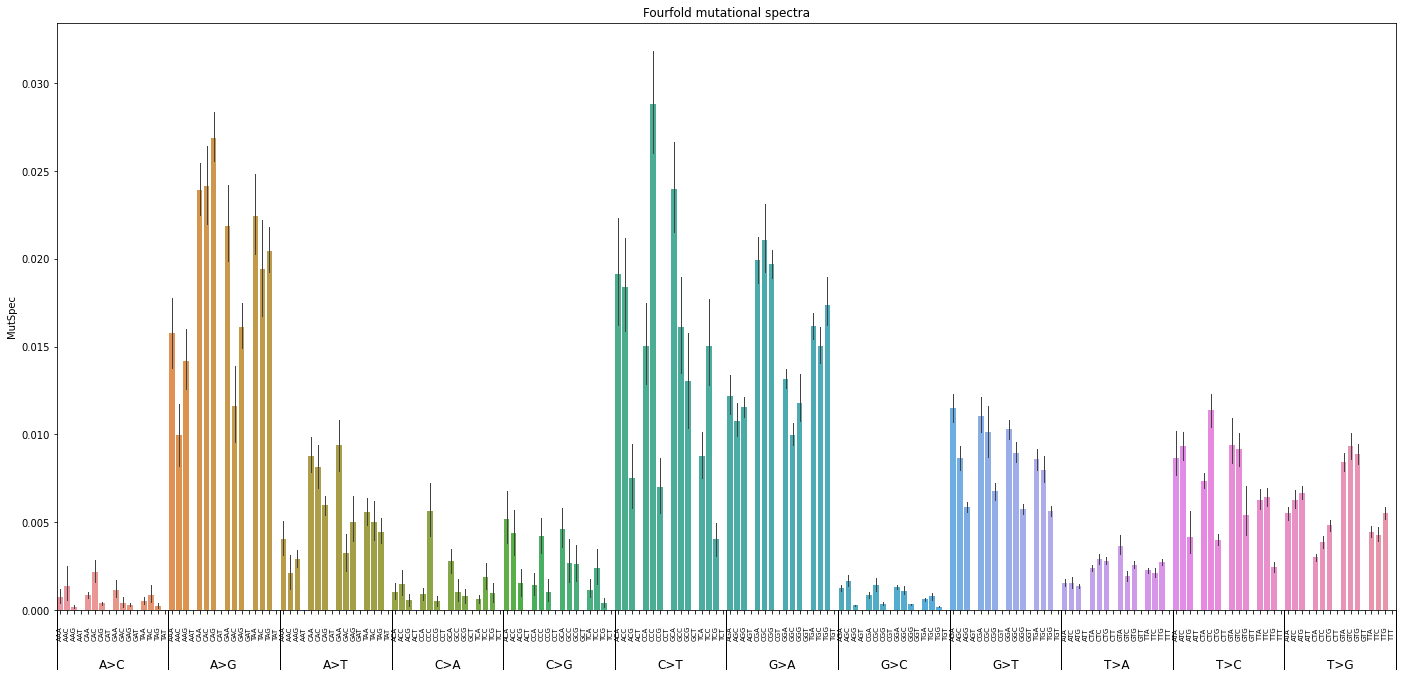

In [44]:
plot_mutspec192(edge_mutspec192_ff, "Fourfold mutational spectra")

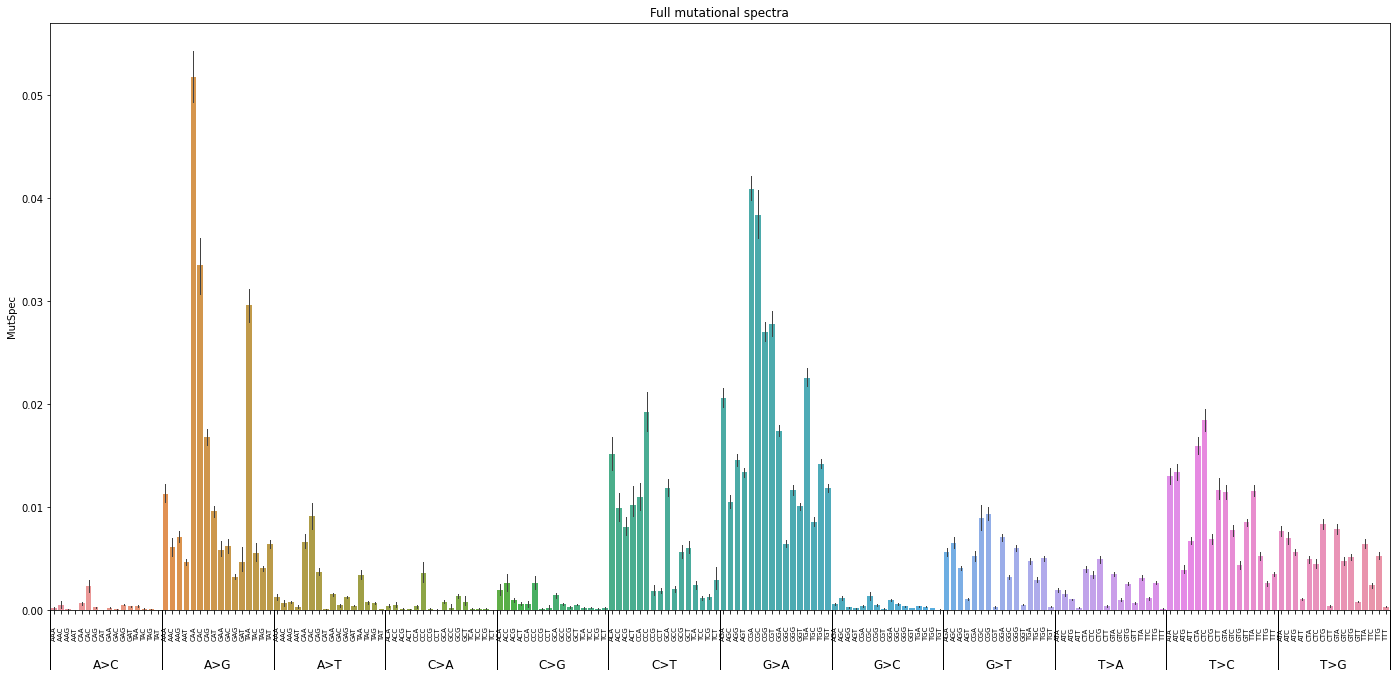

In [45]:
plot_mutspec192(edge_mutspec192_all, "Full mutational spectra")

In [14]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"

    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")


<AxesSubplot:>

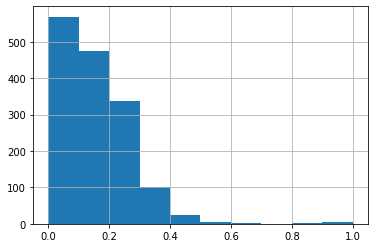

In [11]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist()


### Reformat mutspec

In [29]:
import os
import warnings

warnings.filterwarnings("ignore")

In [12]:
PATH_TO_DIR_OF_EDGE_MUTSPEC = "../data/processed/for_signatures/"

In [30]:
grouped = edge_mutspec192_ff.groupby("AltNode")
for gname in edge_mutspec192_ff.AltNode.unique():
    cur_gr = grouped.get_group(gname)
    assert len(cur_gr) == 192
    cur_gr["NucSubst"] = cur_gr.Mut.str.get(0) + cur_gr.Mut.str.get(2) + cur_gr.Mut.str.get(-1) + ">" + \
                        cur_gr.Mut.str.get(0) + cur_gr.Mut.str.get(-3) + cur_gr.Mut.str.get(-1)
    
    cur_gr = cur_gr[["NucSubst", "RawMutSpec"]]
    cur_gr.to_csv(os.path.join(PATH_TO_DIR_OF_EDGE_MUTSPEC, gname + ".csv"), index=None)